## Getting the data
We obtain the data using Google Big Query.
In order to obtain the deposits and withdrawals transactions, just run the following querys:

### Withdrawals 
SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions` WHERE `to_address` 
IN (SELECT `address` FROM `tornado_cash_transactions.tornadocontracts`) AND SUBSTR(`input`, 1, 10) = "0x21a0adb6";

### Deposits
SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions` WHERE `to_address` 
IN (SELECT `address` FROM `tornado_cash_transactions.tornadocontracts`) AND SUBSTR(`input`, 1, 10) = "0xb214faa5";

References here:
https://github.com/Phread420/tornado_bigquery/blob/main/Notes.md

This results are stored in the following files:
- withdraw_transactions.csv
- deposit_transactions.csv

After obtaining those two files, the next thing to do is to get the "recipient_addresses" that are making the withdrawl (if the user withdraws via a relayer, the relayer's account will be displayed in the "from_addres" field). That information is encoded in the "input" field of the withdrawal transactions.

The process to do so is in the following notebook:
https://github.com/lambdaclass/tornado_cash_anonymity_tool/blob/main/notebooks/complete_withdraw_data_set.ipynb

Note that the recipient addresses obtained in this df are in upper case and the addresses coming from the big query are in lower case, so you have to make the transformation when running the heuristic.

## Second heuristic - Preliminary implementation

### Description

If there is a deposit and a withdraw transaction with **unique** gas prices (e.g., 3.1415926 Gwei), then we consider the deposit and the withdraw transactions linked. The corresponding deposit transaction can be removed from any other withdraw transaction’s anonymity set.

In [52]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load transactions data

withdraw_transactions_df = pd.read_csv("../data/tornado_withdraw_df.csv")
# Change recipient_address to lowercase.
withdraw_transactions_df["recipient_address"] = withdraw_transactions_df["recipient_address"].str.lower()
# Change block_timestamp field to be a timestamp object.
withdraw_transactions_df["block_timestamp"] = withdraw_transactions_df["block_timestamp"].apply(pd.Timestamp)

deposit_transactions_df = pd.read_csv("../data/deposit_transactions.csv")
# Change block_timestamp field to be a timestamp object.
deposit_transactions_df["block_timestamp"] = deposit_transactions_df["block_timestamp"].apply(pd.Timestamp)

# tornado_addresses = pd.read_csv("../data/tornadocontracts_abi.csv", names=['address', 'contract_value', '3', '4'])

### Function summary: filter_by_unique_gas_price

Filters a transaction DataFrame, leaving only the transactions (rows) that have unique gas_price within all transactions.

In [3]:
def filter_by_unique_gas_price(transactions_df):
    
    # Count the appearances of each gas price in the transactions DataFrame.
    
    gas_prices_count = transactions_df["gas_price"].value_counts()
    
    # Filter the gas prices that are unique, i.e., the ones with a count equal to 1.
    # The gas prices are stored in unique_gas_prices
    
    unique_gas_prices = gas_prices_count[gas_prices_count == 1].keys()
    
    # Return the transactions that verify having these unique gas price values.
    
    return transactions_df[transactions_df["gas_price"].isin(unique_gas_prices)]    

A test of the function applied to our deposit transactions data.

In [4]:
unique_gas_price_deposits = filter_by_unique_gas_price(deposit_transactions_df)
unique_gas_price_deposits

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
3,0xbd83053f8afa7777f54a4aca6b8e112fa31b888922dc...,7,63,0x6c6e4816ecfa4481472ff88f32a3e00f2eaa95a1,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,100000000000000000,800000,30838446643,0xb214faa527a20ba920c8ae877d67ce1ebd7420dafb31...,6222489,...,NaN,NaN,0,2020-05-27 03:30:44+00:00,10145408,0x837b3482443f027f6f045644bf002243f72304686015...,NaN,NaN,NaN,30838446643
10,0x6c416af65ea3a4bc096663c94f5b1fb0cba91607f617...,3,51,0x27972d10f153099b3649ea8546a11d91315455e5,0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f,0,1200000,71302125000,0xb214faa52d8f3e8b9934e70c0fbf5bb3cf355027815a...,4108630,...,NaN,NaN,1,2020-09-26 08:10:08+00:00,10937092,0x32f0f0fd04d3af8210d2eb956fdec21e09ebff5a5520...,NaN,NaN,NaN,71302125000
12,0x830dbd534d13cd43cb078b7cad8a9c5137bb19aa8bf3...,0,63,0x43eefeb3db479e7b22e015572f38b6af633a43ff,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,1000000000000000000,275000,595000000000,0xb214faa500fe7a849e7374f033604417bf6ccd369ea6...,4390453,...,NaN,NaN,0,2020-09-17 20:50:21+00:00,10881994,0x5270afd78906cc7264620b2c6fbf8c9221cf8053c811...,NaN,NaN,NaN,595000000000
72,0x3fc1bccbcb3d55967104809fa30b97e841d1cac61259...,90,49,0x1f28f2ef476178baa1bdd52a7dd666046d87288f,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,100000000000000000,1200000,2940860215,0xb214faa509ab186ab3c0fc40dd60fcd3387d430adad5...,4928980,...,NaN,NaN,1,2020-02-22 16:58:22+00:00,9534369,0x275673e2c9caec96e76b9c86e7485ea7ec707ee2c57b...,NaN,NaN,NaN,2940860215
81,0x90b978750a56c400bae91ad65e1cf2abe45b1218defe...,26,57,0x823c54e4fc30665ebcf045d85aa0dae04015670d,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,100000000000000000,1200000,2047069131,0xb214faa50c8acbec5f24055cdc9600ad6523ebd062da...,2905958,...,NaN,NaN,1,2020-01-24 23:45:33+00:00,9347529,0x4ef1e187ceae83f51f847f39c9355a124317fc769670...,NaN,NaN,NaN,2047069131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24184,0x8e58b6fc1ad71fad1026d747e657e661b9811f9825b6...,49,7,0x4ba62abb7d1090d3cfb2808476f13751995c60a0,0xa160cdab225685da1d56aa342ad8841c3b53f291,100000000000000000000,1200000,77000000008,0xb214faa50853185b07a0bfa6f066ee5ebb65fedb3632...,1405545,...,NaN,NaN,1,2020-11-18 13:14:16+00:00,11282145,0x8e643dd6743f2a37f3d69d3d933606cd125560fe96ca...,NaN,NaN,NaN,77000000008
24186,0x144d1da795c74fc8790b643a47a92d22b2b013aa150e...,418,23,0xeb8efa8cad41e89986aef7e896a06fb2f1f7e932,0xa160cdab225685da1d56aa342ad8841c3b53f291,100000000000000000000,1200000,88738010113,0xb214faa51e21e8e72602f74751afabb234e9a9de6b51...,3619096,...,NaN,NaN,1,2020-12-15 23:52:43+00:00,11460716,0xc7c58c9d0c03009f0f9a95a7031ddd09a6a3802708f9...,NaN,NaN,NaN,88738010113
24209,0xcf3a2c4a9c9a8b3597037f0c1001b13f87786f5c5288...,4,129,0x73a61026393cf7e86da37c4c1449797daa57f025,0xa160cdab225685da1d56aa342ad8841c3b53f291,100000000000000000000,1200000,70160000000,0xb214faa511b2549541f332fdcf73b5b93b3f02133183...,7896972,...,NaN,NaN,1,2020-11-23 02:30:12+00:00,11311799,0xf5ac8e976a4619c726a1b0ec890f89f31a5d7b02ea02...,NaN,NaN,NaN,70160000000
24223,0x30e194ec30d1a2be7c4e3f1d305a99de31121eb0aaa2...,67,206,0x317e0116e98b9f2b074a1dffff03c9d7d69cf9cc,0xa160cdab225685da1d56aa342ad8841c3b53f291,100000000000000000000,1200000,95001000000,0xb214faa52e0de5dad758d07ca570a9a9d8c194da97c6...,12092120,...,NaN,NaN,1,2020-09-28 04:53:05+00:00,10948972,0x78610f380136843c3af9a65dd66ca112048fc468d42d...,NaN,NaN,NaN,95001000000


### Function summary: same_gas_price_heuristic

This function receives a particular withdraw transaction and a DataFrame with the unique gas price deposits.

It returns a tuple:
* $(True, deposit$ $hash)$ when a deposit transaction with the same gas price as the withdrawal transaction is found.
* $(False, None)$ when such a deposit is not found.

In [5]:
def same_gas_price_heuristic(withdrawal_transaction, unique_gas_price_deposit_df):
    
    # Iterate over each deposit transaction of unique_gas_price_deposit_df
    for index, deposit_row in unique_gas_price_deposit_df.iterrows():
        
        # When a deposit transaction with the same gas price as the withdrawal transaction is found, and
        # it also satisfies having an earlier timestamp than it, the tuple (True, deposit_hash) is returned.
        if (withdrawal_transaction.gas_price == deposit_row.gas_price) and (withdrawal_transaction.block_timestamp > deposit_row.block_timestamp):
            return (True, deposit_row.hash)
        
    return (False, None)

In [6]:
same_gas_price_heuristic(withdraw_transactions_df.iloc[2], unique_gas_price_deposits)

(False, None)

### Function summary: apply_same_gas_price_heuristic

Applies the heuristic to all the withdraw_transactions DataFrame. Returns a dicionary mapping linked withdrawal and deposit transaction hashes.

In [7]:
def apply_same_gas_price_heuristic(deposit_transactions_df, withdraw_transactions_df):
    
    # Get deposit transactions with unique gas prices.
    
    unique_gas_price_deposits = filter_by_unique_gas_price(deposit_transactions_df)
    
    # Initialize an empty dictionary to store the linked transactions.
    
    withdrawal_to_deposit = {}
    
    # Iterate over the withdraw transactions.
    for index, withdraw_row in withdraw_transactions_df.iterrows():
        
        # Apply heuristic for the given withdraw transaction.
        same_gas_deposit_hash = same_gas_price_heuristic(withdraw_row, unique_gas_price_deposits)
        
        # When a deposit transaction matching the withdraw transaction gas price is found, add
        # the linked transactions to the dictionary.
        if same_gas_deposit_hash[0]:
            withdrawal_to_deposit[withdraw_row.hash] = same_gas_deposit_hash[1]

    # Return the linked transactions dictionary.
    return withdrawal_to_deposit

In [8]:
linked_transactions = apply_same_gas_price_heuristic(deposit_transactions_df, withdraw_transactions_df)

In [10]:
linked2 = pd.DataFrame.from_dict({"withdraw_hashes": linked_transactions.keys(), "deposit_hashes": linked_transactions.values()})

In [77]:
timeInThePool = [] ##number of days ppl leave their funds in the TC pool and we were able to link them using Heuristic2
for i in range(linked2.shape[0]):
    withdrawHash = linked2.iloc[[i]]["withdraw_hashes"]
    wHash = withdrawHash.values.tolist()[0]
    wTimestamp = withdraw_transactions_df[withdraw_transactions_df["hash"]==wHash]["block_timestamp"].values.tolist()[0]
    depositHash = linked2.iloc[[i]]["deposit_hashes"]
    dHash = depositHash.values.tolist()[0]
    dTimestamp = deposit_transactions_df[deposit_transactions_df["hash"]==dHash]["block_timestamp"].values.tolist()[0]
    timeInThePool.append((wTimestamp-dTimestamp)/10**9/86400)

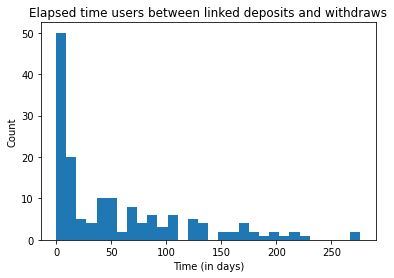

In [80]:
plt.hist(timeInThePool,bins=30)
plt.xlabel("Time (in days)")
plt.ylabel("Count")
plt.title("Elapsed time users between linked deposits and withdraws")
plt.show()